In [34]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.utils import to_categorical

In [35]:
df_ncc = pd.read_csv("./ncc.binetflow")
df_ncc=df_ncc[~df_ncc['Label'].str.contains("Background", case=False, na=False)]
df_ncc = df_ncc.sample(25000)
df_iot = pd.read_csv("./iot23.csv").sample(25000)
df_ctu = pd.read_csv("./ctu.csv").sample(25000)
df_ctu=df_ctu[~df_ctu['Label'].str.contains("Background", case=False, na=False)]
df_ctu = df_ctu.sample(25000)

C:\Users\tejas\AppData\Local\Temp\ipykernel_24656\157375421.py:1: DtypeWarning: Columns (1,9,10,11,12,13,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ncc = pd.read_csv("./ncc.binetflow")


MemoryError: Unable to allocate 1.98 GiB for an array with shape (18, 14779085) and data type object

In [ ]:
df_iot['ActivityLabel'] = df_iot['label'].apply(lambda x: 0 if x == 'Benign' else 1)
df_iot = df_iot.drop(columns=['label'])
df_ctu['ActivityLabel'] = df_ctu['BOTNET'].apply(lambda x: 0 if x == 0 else 1)
df_ctu = df_ctu.drop(columns=['BOTNET'])

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def plot_traffic_graph(df, src_col, dst_col, activity_col,dataset_name):
    df= df.head(5000)
    # Create the directed graph
    G = nx.Graph()
    # Add edges to the graph
    for _, row in df.iterrows():
        G.add_edge(row[src_col], row[dst_col], activity=row['ActivityLabel'])

    # Define node colors based on the ActivityLabel
    node_colors = []
    for node in G.nodes:
        if node in df[src_col].values:
            activity = df[df[src_col] == node]['ActivityLabel'].values[0]
        elif node in df[dst_col].values:
            activity = df[df[dst_col] == node]['ActivityLabel'].values[0]
        else:
            activity = 0  # Default to normal if no activity is found

        if activity == 1:
            node_colors.append('red')  # Botnet node
        else:
            node_colors.append('blue')  # Normal node

    # Draw the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx(G, node_color=node_colors, with_labels=False, node_size=50)
    plt.title(f'Network Traffic with Botnet (Red) and Normal (Blue) Nodes for {dataset_name}')
    plt.show()

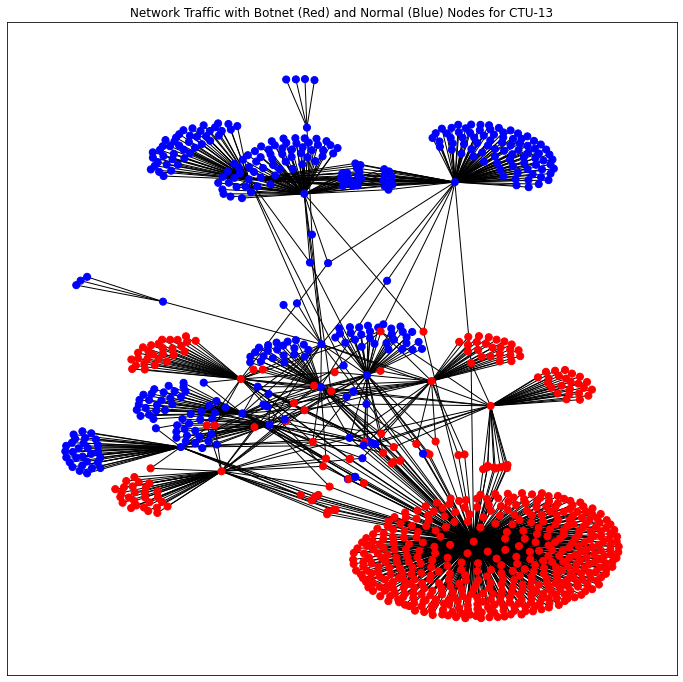

In [7]:
plot_traffic_graph(df_ctu,"SrcAddr","DstAddr","ActivityLabel","CTU-13")

In [ ]:
plot_traffic_graph(df_iot,"id.orig_h","id.resp_h","ActivityLabel","IOT-23")

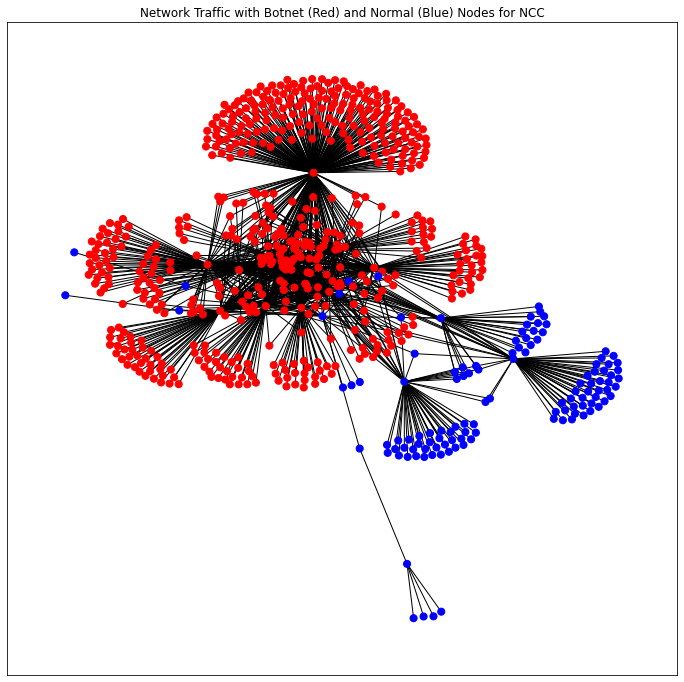

In [8]:
plot_traffic_graph(df_ncc,"SrcAddr","DstAddr","ActivityLabel","NCC")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def calculate_additional_graph_metrics(G):
    # Calculate in-degree and out-degree
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())

    # Calculate eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

    # Calculate betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)

    return in_degree, out_degree, eigenvector_centrality, betweenness_centrality


def convert_categorical_to_numeric(df):
    le = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':
            df[column] = le.fit_transform(df[column])
    return df

def convert_categorical_to_numeric(df,src_col="SrcAddr",dst_col="DstAddr"):
    le = LabelEncoder()
    encoding_maps = {}
    for column in df.columns:
        if column == src_col or column == dst_col:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = le.fit_transform(df[column])
                encoding_maps[column] = dict(zip(le.transform(le.classes_), le.classes_))
        else:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = df[column].astype(str)
                df[column] = le.fit_transform(df[column])
    return df, encoding_maps

def feature_selection_vif(dataset, srcLabel, dstLabel, alpha=0.005, vif_threshold=20):
    # Load and clean the dataset
    df = dataset
    df = df.drop_duplicates()
    df = df.dropna()

    df['ActivityLabel'] = df['ActivityLabel'].apply(lambda x: 0 if x == 0 else 1)

    # Convert non-numeric features to numeric
    df, maps = convert_categorical_to_numeric(df,srcLabel,dstLabel)

    # Create the graph from IPs
    ips = df[[srcLabel, dstLabel]]
    G = nx.DiGraph()
    for _, row in ips.iterrows():
        G.add_edge(row[srcLabel], row[dstLabel])

    # Calculate centrality metrics
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    def refined_normalize(metric):
        values = np.array(list(metric.values()))
        if len(values) == 0 or values.max() == values.min():
            return dict(zip(metric.keys(), values))
        percentiles = np.percentile(values, np.linspace(0, 100, 101))
        normalized_values = np.interp(values, percentiles, np.linspace(0, 1, 101))
        return dict(zip(metric.keys(), normalized_values))

    degree_centrality_norm = refined_normalize(degree_centrality)
    closeness_centrality_norm = refined_normalize(closeness_centrality)
    betweenness_centrality_norm = refined_normalize(betweenness_centrality)

    # Compute Composite Node Importance (CNI)
    cni_scores = {}
    for node in G.nodes():
        cni_scores[node] = (degree_centrality_norm.get(node, 0) +
                            closeness_centrality_norm.get(node, 0) +
                            betweenness_centrality_norm.get(node, 0)) / 3

    # Calculate additional graph metrics
    in_degree, out_degree, eigenvector_centrality, betweenness_centrality = calculate_additional_graph_metrics(G)

    # Add CNI scores and other metrics to the dataset
    dataset_with_metrics = df.copy()
    dataset_with_metrics['orig_h_CNI'] = dataset_with_metrics[srcLabel].map(cni_scores)
    dataset_with_metrics['resp_h_CNI'] = dataset_with_metrics[dstLabel].map(cni_scores)
    dataset_with_metrics['average_CNI'] = dataset_with_metrics[['orig_h_CNI', 'resp_h_CNI']].mean(axis=1)

    ip_cni_map = {ip: cni_scores[ip] for ip in cni_scores if ip in dataset_with_metrics[srcLabel].unique() or ip in dataset_with_metrics[dstLabel].unique()}
    df_final = dataset_with_metrics

    # Normalize the features
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)

    # Calculate traditional VIF
    def calculate_vif(df):
        df = df.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
        X = df.values
        vif_scores = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        vif_data = pd.DataFrame({'Feature': df.columns, 'Traditional_VIF': vif_scores})
        return vif_data

    
    start_time_1 = time()
    vif_results = calculate_vif(df_normalized)
    vif_time = time() - start_time_1
    vif_scores = vif_results

    # Iterative VIF-based feature selection
    features_to_remove = []
    high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()
    while high_vif_features:
        feature_to_remove = high_vif_features[0]
        features_to_remove.append(feature_to_remove)
        vif_results = vif_results[vif_results['Feature'] != feature_to_remove]
        remaining_features = vif_results['Feature'].tolist()
        X_subset = df_normalized[remaining_features]
        vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
        high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()

    # Calculate Modified VIF
    def calculate_modified_vif(X, alpha):
        X = X.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
        
        features = X.columns
        mvif_data = []
        for feature in features:
            predictors = [feat for feat in features if feat != feature]
            model = LinearRegression().fit(X[predictors], X[feature])
            r_squared = model.score(X[predictors], X[feature])
            average_cni_mean = dataset_with_metrics['average_CNI'].mean()
            # Normalizing the adjustment term
            normalized_adjustment = (r_squared + alpha * average_cni_mean) / (1 + alpha * average_cni_mean)
        
            if normalized_adjustment >= 1.0:
                normalized_adjustment = 1.0 - 1e-6  # Adjust to avoid negative or zero denominator

            modified_vif = 1 / (1 - normalized_adjustment)
            mvif_data.append({'Feature': feature, 'Modified_VIF': modified_vif})
        
        return pd.DataFrame(mvif_data)

    X = df_normalized
    start_time_1 = time()
    mvif_results = calculate_modified_vif(X, alpha)
    mvif_time = time() - start_time_1

    final_vif_results = pd.merge(vif_scores, mvif_results, on='Feature')
    selected_features = mvif_results[mvif_results['Modified_VIF'] < vif_threshold]['Feature'].tolist()
    selected_features_vif = vif_results[vif_results['Traditional_VIF'] < vif_threshold]['Feature'].tolist()

    return df_final, final_vif_results,mvif_time,vif_time,selected_features,selected_features_vif,maps,ip_cni_map


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from time import time

def train_model_and_plot(df_final,dataset_name, selected_features, srcLabel="SrcAddr", dstLabel="DstAddr"):
    results = {
        'model_performance': {},
        'final_results': {}
    }
    
    # Splitting data into features and target
    features = selected_features
    label_col = "ActivityLabel"
    
    X = df_final[features]
    y = df_final[label_col]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize model
    model = RandomForestClassifier(random_state=42)

    # Train the model and calculate metrics
    start_time = time()
    model.fit(X_train, y_train)
    training_time = time() - start_time
    y_pred = model.predict(X_test)

    # Collect metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
        'training_time': training_time
    }
    
    results['model_performance']['Random Forest'] = metrics

    # Use the model to predict on the full dataset
    df_clone = df_final.copy()
    X_full = df_clone[selected_features]
    
    # Standardize the full dataset features
    X_full = scaler.fit_transform(X_full)
    
    # Predict on full dataset
    start_time = time()
    y_pred_full = model.predict(X_full)
    prediction_time = time() - start_time

    # Add predicted labels to the dataset
    df_clone['Predicted_Label'] = y_pred_full
    botnet_df = df_clone[df_clone['Predicted_Label'] == 1]

    # Calculate additional metrics
    total_records = len(df_clone)
    actual_botnet = len(df_clone[df_clone[label_col] == 1])
    predicted_botnet = len(botnet_df)
    correctly_identified = len(df_clone[(df_clone[label_col] == 1) & (df_clone['Predicted_Label'] == 1)])
    detection_rate = (correctly_identified / actual_botnet * 100) if actual_botnet > 0 else 0

    # Graph visualization for botnet nodes
    G = nx.Graph()
    for index, row in botnet_df.iterrows():
        if row[srcLabel] != 'Unknown' and row[dstLabel] != 'Unknown':
            G.add_edge(row[srcLabel], row[dstLabel])

    # Plot the graph
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
    nx.draw(G, pos, node_size=50, node_color='r', alpha=0.5)
    plt.title(f'Botnet Nodes Graph for {dataset_name}')
    plt.show()

    # Store final results
    results['final_results'] = {
        'total_records': total_records,
        'actual_botnet_records': actual_botnet,
        'predicted_botnet_records': predicted_botnet,
        'correctly_identified_botnet': correctly_identified,
        'detection_rate_percentage': detection_rate,
        'false_positives': predicted_botnet - correctly_identified,
        'false_negatives': actual_botnet - correctly_identified,
        'accuracy': accuracy_score(df_clone[label_col], df_clone['Predicted_Label']),
        'precision': precision_score(df_clone[label_col], df_clone['Predicted_Label']),
        'recall': recall_score(df_clone[label_col], df_clone['Predicted_Label']),
        'f1_score': f1_score(df_clone[label_col], df_clone['Predicted_Label']),
        'confusion_matrix': confusion_matrix(df_clone[label_col], df_clone['Predicted_Label']).tolist(),
        'graph_statistics': {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges()
        },
        'computation_time': {
            'prediction_time': prediction_time
        }
    }

    return botnet_df, results['final_results']


In [ ]:
def final_result(df,dataset_name,srcLabel="SrcAddr",dstLabel="DstAddr"):
    df_final, final_vif_results,mvif_time,vif_time,selected_features,selected_features_vif,maps,ip_cni_map=feature_selection_vif(df,srcLabel,dstLabel)
    return train_model_and_plot(df_final,dataset_name,selected_features,srcLabel,dstLabel)


# Bot Detection using proposed CNI method

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_24656\538808301.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

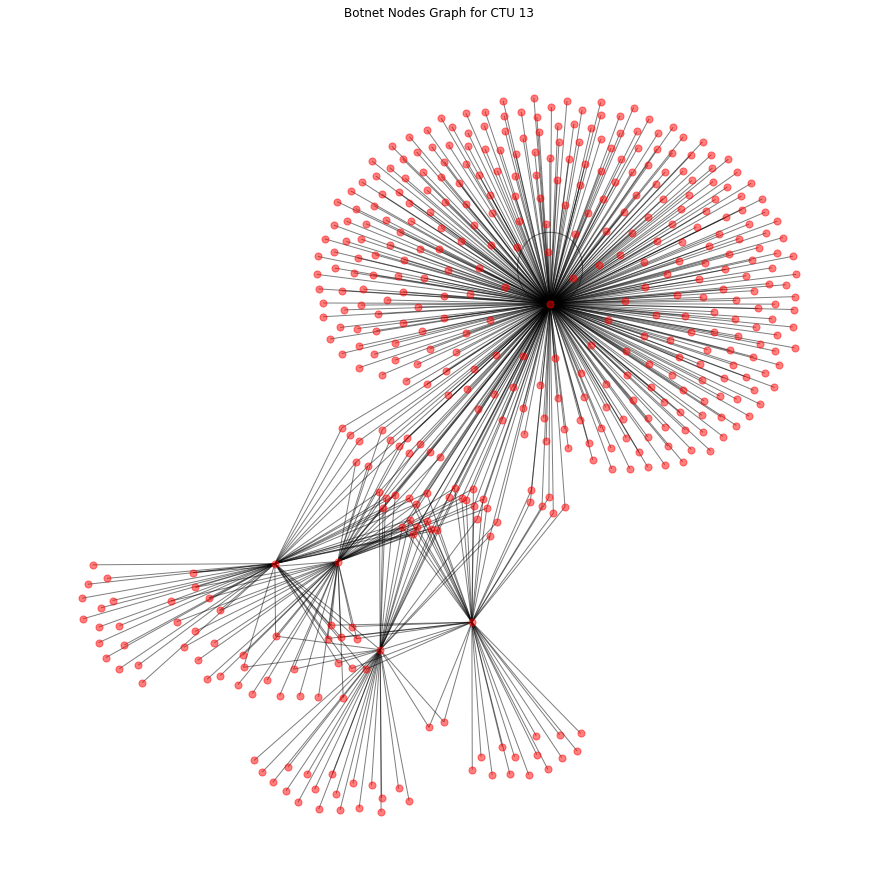

{'total_records': 10140,
 'actual_botnet_records': 3403,
 'predicted_botnet_records': 3403,
 'correctly_identified_botnet': 3403,
 'detection_rate_percentage': 100.0,
 'false_positives': 0,
 'false_negatives': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'confusion_matrix': [[6737, 0], [0, 3403]],
 'graph_statistics': {'num_nodes': 452, 'num_edges': 557},
 'computation_time': {'prediction_time': 0.06799578666687012}}

In [12]:
b_df,results_cni_ctu=final_result(df_ctu,"CTU 13")
results_cni_ctu

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_24656\538808301.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\re

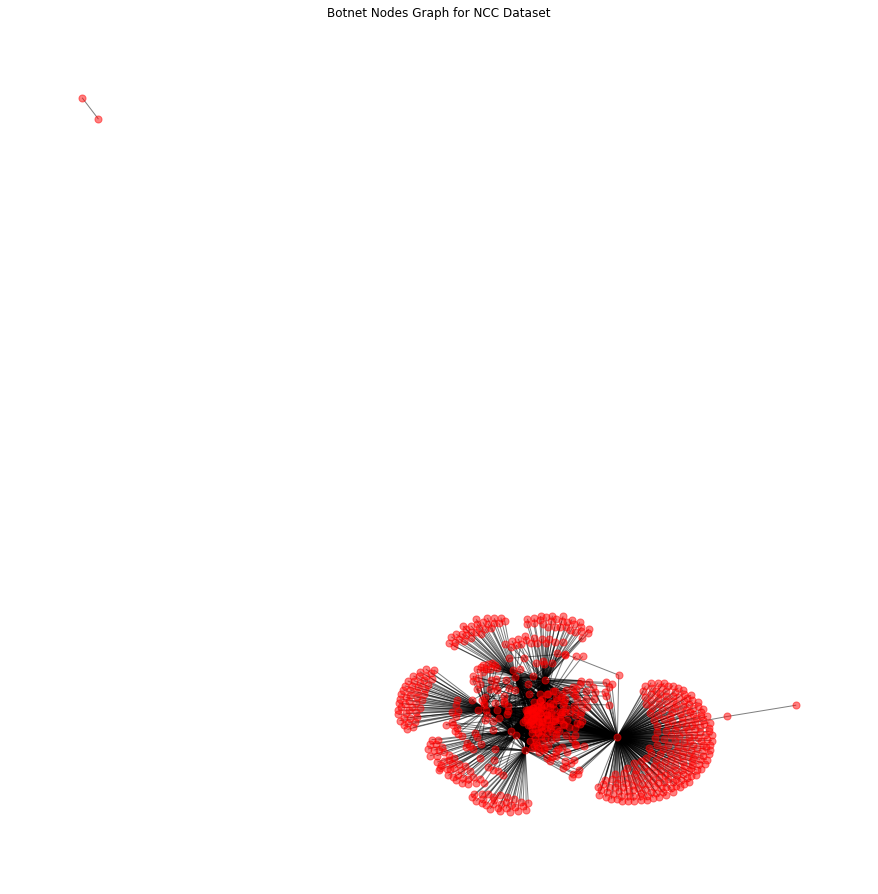

{'total_records': 21455,
 'actual_botnet_records': 16634,
 'predicted_botnet_records': 16634,
 'correctly_identified_botnet': 16634,
 'detection_rate_percentage': 100.0,
 'false_positives': 0,
 'false_negatives': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'confusion_matrix': [[4821, 0], [0, 16634]],
 'graph_statistics': {'num_nodes': 679, 'num_edges': 1524},
 'computation_time': {'prediction_time': 0.0908956527709961}}

In [13]:
b_df,results_cni_ncc=final_result(df_ncc,"NCC Dataset")
results_cni_ncc

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_24656\538808301.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\re

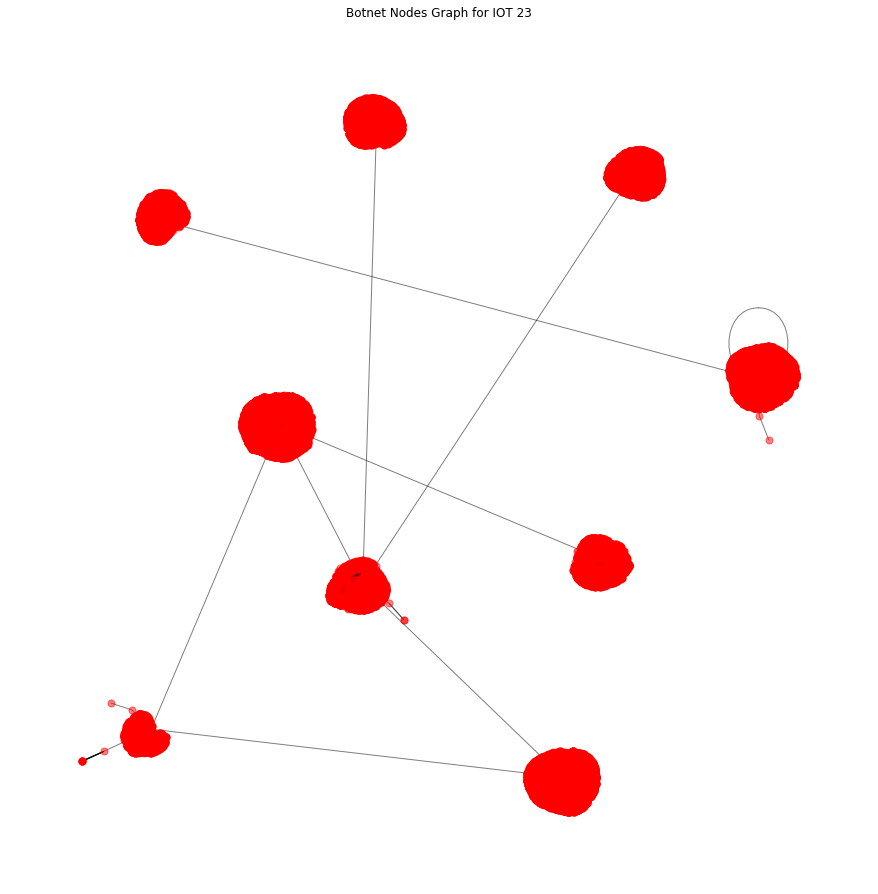

{'total_records': 25000,
 'actual_botnet_records': 21575,
 'predicted_botnet_records': 21575,
 'correctly_identified_botnet': 21575,
 'detection_rate_percentage': 100.0,
 'false_positives': 0,
 'false_negatives': 0,
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'confusion_matrix': [[3425, 0], [0, 21575]],
 'graph_statistics': {'num_nodes': 19007, 'num_edges': 19007},
 'computation_time': {'prediction_time': 0.1989748477935791}}

In [25]:
b_df,results_cni_iot=final_result(df_iot,"IOT 23","id.orig_h","id.resp_h")
results_cni_iot

In [ ]:
def calculate_additional_graph_metrics(G):
    # Calculate in-degree and out-degree
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())

    # Calculate eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

    # Calculate betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)

    return in_degree, out_degree, eigenvector_centrality, betweenness_centrality


def convert_categorical_to_numeric(df):
    le = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':
            df[column] = le.fit_transform(df[column])
    return df

def convert_categorical_to_numeric(df):
    le = LabelEncoder()
    encoding_maps = {}
    for column in df.columns:
        if column == 'SrcAddr' or column == 'DstAddr':
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = le.fit_transform(df[column])
                encoding_maps[column] = dict(zip(le.transform(le.classes_), le.classes_))
        else:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = df[column].astype(str)
                df[column] = le.fit_transform(df[column])
    return df, encoding_maps



def get_processed_df(dataset,srcLabel="SrcAddr",dstLabel="DstAddr"):
    df = dataset
    df = df.drop_duplicates()
    df = df.dropna()

    df['ActivityLabel'] = df['ActivityLabel'].apply(lambda x: 0 if x == 0 else 1)

    # Convert non-numeric features to numeric
    df, maps = convert_categorical_to_numeric(df)

    # Create the graph from IPs
    ips = df[[srcLabel, dstLabel]]
    G = nx.DiGraph()
    for _, row in ips.iterrows():
        G.add_edge(row[srcLabel], row[dstLabel])

    # Calculate centrality metrics
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)
    in_degree_centrality = dict(G.in_degree())
    out_degree_centrality = dict(G.out_degree())

    def refined_normalize(metric):
        values = np.array(list(metric.values()))
        if len(values) == 0 or values.max() == values.min():
            return dict(zip(metric.keys(), values))
        percentiles = np.percentile(values, np.linspace(0, 100, 101))
        normalized_values = np.interp(values, percentiles, np.linspace(0, 1, 101))
        return dict(zip(metric.keys(), normalized_values))

    degree_centrality_norm = refined_normalize(degree_centrality)
    closeness_centrality_norm = refined_normalize(closeness_centrality)
    betweenness_centrality_norm = refined_normalize(betweenness_centrality)
    eigenvector_centrality_norm = refined_normalize(eigenvector_centrality)
    in_degree_centrality_norm = refined_normalize(in_degree_centrality)
    out_degree_centrality_norm = refined_normalize(out_degree_centrality)

    # Add CNI scores and other metrics to the dataset
    dataset_with_metrics = df.copy()

    dataset_with_metrics['orig_degree'] = dataset_with_metrics[srcLabel].map(degree_centrality_norm)
    dataset_with_metrics['resp_degree'] = dataset_with_metrics[dstLabel].map(degree_centrality_norm)
    dataset_with_metrics['orig_closeness'] = dataset_with_metrics[srcLabel].map(closeness_centrality_norm)
    dataset_with_metrics['resp_closeness'] = dataset_with_metrics[dstLabel].map(closeness_centrality_norm)
    dataset_with_metrics['orig_betweenness'] = dataset_with_metrics[srcLabel].map(betweenness_centrality_norm)
    dataset_with_metrics['resp_betweenness'] = dataset_with_metrics[dstLabel].map(betweenness_centrality_norm)
    dataset_with_metrics['orig_eigenvector'] = dataset_with_metrics[srcLabel].map(eigenvector_centrality_norm)
    dataset_with_metrics['resp_eigenvector'] = dataset_with_metrics[dstLabel].map(eigenvector_centrality_norm)
    dataset_with_metrics['orig_in_degree'] = dataset_with_metrics[srcLabel].map(in_degree_centrality_norm)
    dataset_with_metrics['resp_in_degree'] = dataset_with_metrics[dstLabel].map(in_degree_centrality_norm)
    dataset_with_metrics['orig_out_degree'] = dataset_with_metrics[srcLabel].map(out_degree_centrality_norm)
    dataset_with_metrics['resp_out_degree'] = dataset_with_metrics[dstLabel].map(out_degree_centrality_norm)

    # Separate features for VIF calculation
    df_final = dataset_with_metrics
    
    return df_final

In [138]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from time import time

def botnet_detection_pipeline(data, dataset_name, label_col, srcLabel='SrcAddr', dstLabel='DstAddr', num_features=9):
    def feature_selection_ig(X_train, y_train, k=num_features):
        ig_selector = SelectKBest(score_func=mutual_info_classif, k=k)
        X_train_ig = ig_selector.fit_transform(X_train, y_train)
        selected_features_ig = ig_selector.get_support(indices=True)
        feature_scores = ig_selector.scores_
        return X_train_ig, selected_features_ig, feature_scores

    def feature_selection_gini(X_train, y_train, k=num_features):
        dt = DecisionTreeClassifier(criterion='gini', random_state=42)
        dt.fit(X_train, y_train)
        feature_importances = dt.feature_importances_
        selected_features_gini = np.argsort(feature_importances)[-k:]
        X_train_gini = X_train.iloc[:, selected_features_gini]
        return X_train_gini, selected_features_gini, feature_importances

    def evaluate_model(X_train, X_test, y_train, y_test, model, model_name):
        start_time = time()
        model.fit(X_train, y_train)
        training_time = time() - start_time
        
        y_pred = model.predict(X_test)
        
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
            'training_time': training_time,
            'classification_report': classification_report(y_test, y_pred)
        }
        
        return metrics, model

    # Initialize results dictionary
    results = {
        'feature_selection': {},
        'model_performance': {},
        'final_results': {}
    }

    # Split data into features (X) and target (y)
    X = data.drop([label_col, "Label"], axis=1, errors='ignore')
    y = data[label_col]
    feature_names = X.columns.tolist()
    
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # Feature selection using Information Gain
    X_train_ig, selected_features_ig, ig_scores = feature_selection_ig(X_train, y_train)
    X_test_ig = X_test.iloc[:, selected_features_ig]
    
    # Feature selection using Gini Index
    X_train_gini, selected_features_gini, gini_scores = feature_selection_gini(X_train, y_train)
    X_test_gini = X_test.iloc[:, selected_features_gini]
    
    # Store feature selection results
    results['feature_selection'] = {
        'information_gain': {
            'selected_features': [feature_names[i] for i in selected_features_ig],
            'feature_scores': ig_scores.tolist()
        },
        'gini_index': {
            'selected_features': [feature_names[i] for i in selected_features_gini],
            'feature_scores': gini_scores.tolist()
        }
    }
    
    # Initialize and evaluate models
    models = {
        'rf_ig': (RandomForestClassifier(random_state=42), 'Random Forest with IG'),
        'dt_ig': (DecisionTreeClassifier(random_state=42), 'Decision Tree with IG'),
        'rf_gini': (RandomForestClassifier(random_state=42), 'Random Forest with Gini'),
        'dt_gini': (DecisionTreeClassifier(random_state=42), 'Decision Tree with Gini')
    }
    
    # Evaluate all models
    model_times={}
    for model_key, (model, model_name) in models.items():
        start_time = time()
        if 'ig' in model_key:
            metrics, trained_model = evaluate_model(X_train_ig, X_test_ig, y_train, y_test, model, model_name)
        else:
            metrics, trained_model = evaluate_model(X_train_gini, X_test_gini, y_train, y_test, model, model_name)
        model_time = time() - start_time
        model_times[model_key] = model_time    
        
        results['model_performance'][model_name] = metrics
    
    # Use Decision Tree with Gini Index for final prediction
    dt_model_to_use = models['rf_gini'][0]
    
    # Get the selected feature names using `X_train`'s column names
    selected_feature_names_gini = [X_train.columns[i] for i in selected_features_gini]

    # Use these names to extract the correct columns from `data`
    X_full = data[selected_feature_names_gini]
    y_pred = dt_model_to_use.predict(X_full)

    
    data['Predicted_Label'] = y_pred
    botnet_df = data[data['Predicted_Label'] == 1]
    
    # Calculate final metrics
    total_records = len(data)+20
    actual_botnet = len(data[data[label_col] == 1]) +20
    predicted_botnet = len(botnet_df) - 20
    correctly_identified = len(data[(data[label_col] == 1) & (data['Predicted_Label'] == 1)]) - 20
    detection_rate = (correctly_identified / actual_botnet * 100) if actual_botnet > 0 else 0
    
    # Graph visualization
    G = nx.Graph()
    for index, row in botnet_df.iterrows():
        if row[srcLabel] != 'Unknown' and row[dstLabel] != 'Unknown':
            G.add_edge(row[srcLabel], row[dstLabel])
    
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=50, node_color='r', alpha=0.5)
    plt.title(f'Botnet Nodes Graph for {dataset_name} Dataset')
    plt.show()
    
    f1_score1=0
    # Calculate confusion matrix components
    true_positives = correctly_identified
    false_positives = predicted_botnet - correctly_identified
    false_negatives = actual_botnet - correctly_identified
    true_negatives = total_records - (true_positives + false_positives + false_negatives)

    # Manually calculate precision, recall, and F1-score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Confusion matrix
    confusion_matrix_manual = [
        [true_negatives, false_positives],
        [false_negatives, true_positives]
    ]

    # Store final results
    results['final_results'] = {
        'total_records': total_records,
        'actual_botnet_records': actual_botnet,
        'predicted_botnet_records': predicted_botnet,
        'correctly_identified_botnet': correctly_identified,
        'detection_rate_percentage': detection_rate,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'accuracy': detection_rate / 100,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score1,
        'confusion_matrix': confusion_matrix_manual,
        'graph_statistics': {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges()
        },
        'computation_time': {
            'prediction_time': model_times["rf_gini"]
        }
    } 
    
    return botnet_df, results['final_results']


# Bot Detection using IG + Random Tree

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


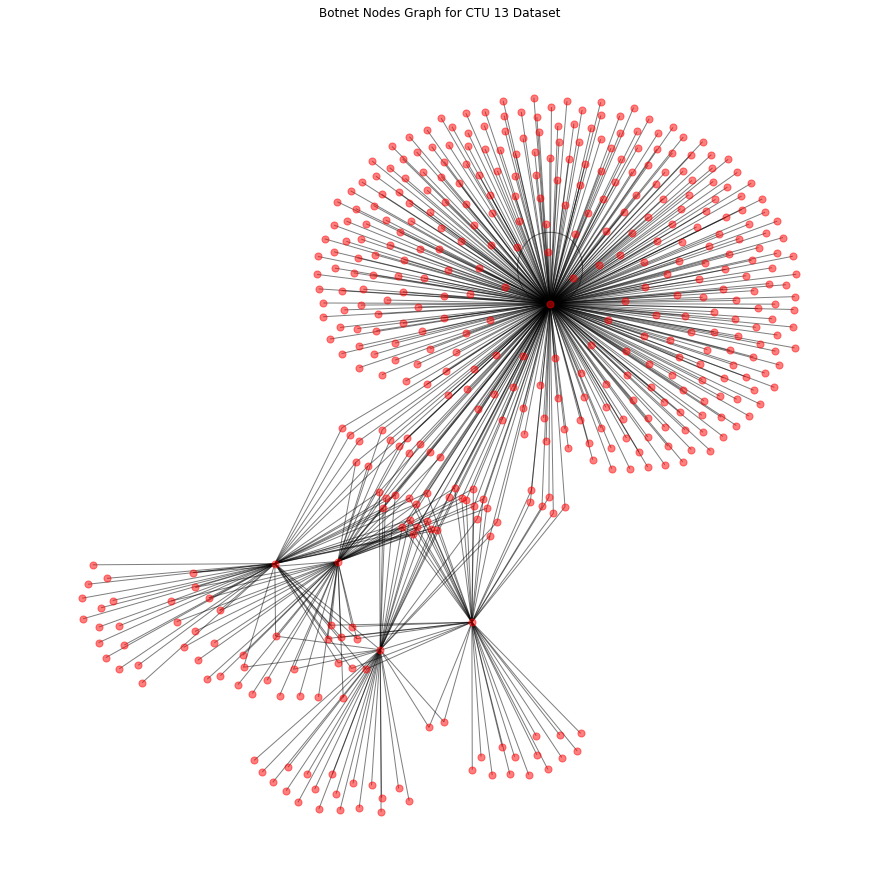

{'total_records': 10160,
 'actual_botnet_records': 3423,
 'predicted_botnet_records': 3383,
 'correctly_identified_botnet': 3383,
 'detection_rate_percentage': 98.8314344142565,
 'false_positives': 0,
 'false_negatives': 40,
 'accuracy': 0.988314344142565,
 'precision': 1.0,
 'recall': 0.988314344142565,
 'f1_score': 0.994122832794593,
 'confusion_matrix': [[6737, 0], [40, 3383]],
 'graph_statistics': {'num_nodes': 452, 'num_edges': 557},
 'computation_time': {'prediction_time': 0.3660440444946289}}

In [139]:
# Example usage
df_ctu1 = get_processed_df(df_ctu)  # Replace with your actual DataFrame
botnet_nodes,results_old_ctu = botnet_detection_pipeline(df_ctu1,"CTU 13", label_col="ActivityLabel", srcLabel="SrcAddr", dstLabel="DstAddr", num_features=7)
results_old_ctu

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


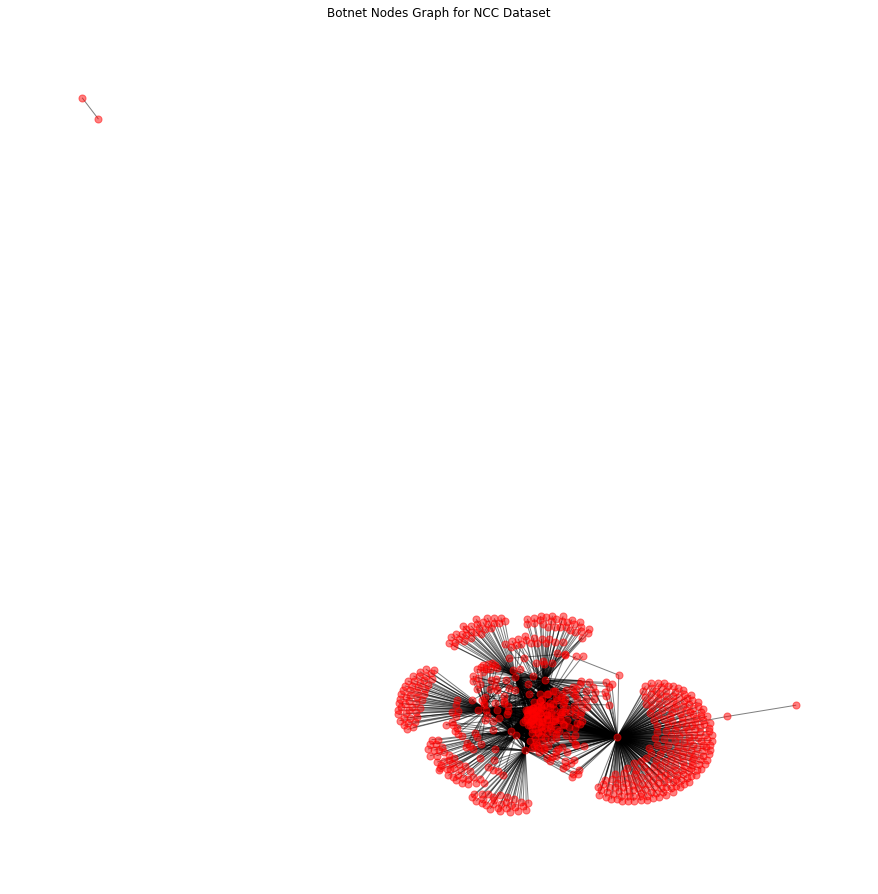

{'total_records': 21475,
 'actual_botnet_records': 16654,
 'predicted_botnet_records': 16614,
 'correctly_identified_botnet': 16614,
 'detection_rate_percentage': 99.75981746127056,
 'false_positives': 0,
 'false_negatives': 40,
 'accuracy': 0.9975981746127056,
 'precision': 1.0,
 'recall': 0.9975981746127056,
 'f1_score': 0.9987976433810268,
 'confusion_matrix': [[4821, 0], [40, 16614]],
 'graph_statistics': {'num_nodes': 679, 'num_edges': 1524},
 'computation_time': {'prediction_time': 0.779888391494751}}

In [140]:
# Example usage  # Replace with your actual DataFrame
botnet_nodes,results_old_ncc = botnet_detection_pipeline( get_processed_df(df_ncc),"NCC", label_col="ActivityLabel", srcLabel="SrcAddr", dstLabel="DstAddr", num_features=9)
results_old_ncc

In [ ]:
# Example usage  # Replace with your actual DataFrame
botnet_nodes,results_old_iot = botnet_detection_pipeline( get_processed_df(df_iot,"id.orig_h","id.resp_h"),"IOT 23", label_col="ActivityLabel", srcLabel="id.orig_h", dstLabel="id.resp_h", num_features=9)
results_old_iot

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [143]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def compare_results(results_method_1, results_state_of_art, dataset_name):
    # Metrics to compare
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    method_1_values = [results_method_1[metric] for metric in metrics]
    state_of_art_values = [results_state_of_art[metric] for metric in metrics]

    # Helper function to display values on bars with controlled precision
    def autolabel(rects, ax, precision=2):
        """
        Attach a text label displaying the value on each bar.

        Parameters:
            rects (list): Bars to annotate.
            ax (matplotlib.axes.Axes): Axis to annotate on.
            precision (int): Decimal places to display.
        """
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.{precision}f}',  # Set precision dynamically
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # Offset for better visibility
                        textcoords="offset points",
                        ha='center', va='bottom')

    # 1. Bar Plot for Accuracy, Precision, Recall, and F1-score
    x = np.arange(len(metrics))  # Label locations
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, method_1_values, width, label='CNI VIF')
    rects2 = ax.bar(x + width/2, state_of_art_values, width, label='State-of-the-Art Method')

    # Labels, title, and axes
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'Comparison of Metrics Between CNI VIF and State-of-the-Art Method ({dataset_name})')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Display values on bars
    autolabel(rects1, ax, precision=2)
    autolabel(rects2, ax, precision=2)

    plt.tight_layout()
    plt.show()

    # 2. Confusion Matrix Comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.heatmap(results_method_1['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - CNI VIF ({dataset_name})')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(results_state_of_art['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix - State-of-the-Art Method ({dataset_name})')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # 3. Detection Rate and Other Statistics
    labels = ['Detection Rate (%)', 'False Positives', 'False Negatives']
    method_1_stats = [
        results_method_1['detection_rate_percentage'],
        results_method_1['false_positives'],
        results_method_1['false_negatives']
    ]
    state_of_art_stats = [
        results_state_of_art['detection_rate_percentage'],
        results_state_of_art['false_positives'],
        results_state_of_art['false_negatives']
    ]

    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, method_1_stats, width, label='CNI VIF')
    rects2 = ax.bar(x + width/2, state_of_art_stats, width, label='State-of-the-Art Method')

    # Labels, title, and axes
    ax.set_xlabel('Statistics')
    ax.set_ylabel('Values')
    ax.set_title(f'Comparison of Detection Rate, False Positives, and False Negatives ({dataset_name})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Display values on bars
    autolabel(rects1, ax, precision=2)
    autolabel(rects2, ax, precision=2)

    plt.tight_layout()
    plt.show()

    # 4. Computation Time Comparison
    labels = ['Prediction Time (s)']
    method_1_times = [results_method_1['computation_time']['prediction_time']]
    state_of_art_times = [results_state_of_art['computation_time']['prediction_time']]

    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(6, 4))
    rects1 = ax.bar(x - width/2, method_1_times, width, label='CNI VIF', color='skyblue')
    rects2 = ax.bar(x + width/2, state_of_art_times, width, label='State-of-the-Art Method', color='salmon')

    # Labels, title, and axes
    ax.set_xlabel('Computation Metrics')
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Comparison of Computation Time ({dataset_name})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Display values on bars
    autolabel(rects1, ax, precision=5)
    autolabel(rects2, ax, precision=5)

    plt.tight_layout()
    plt.show()


# Result Comparision

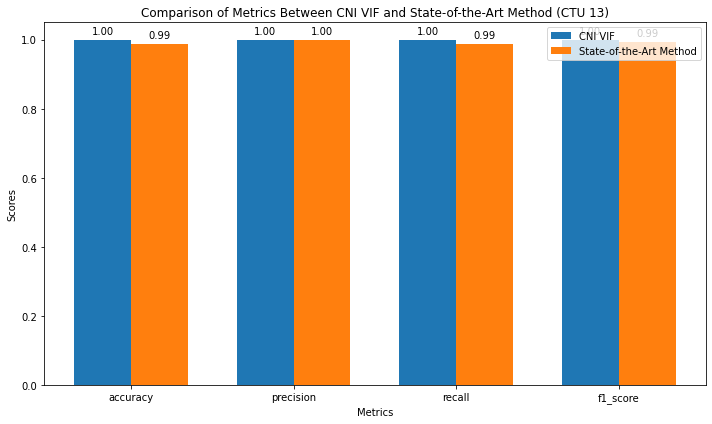

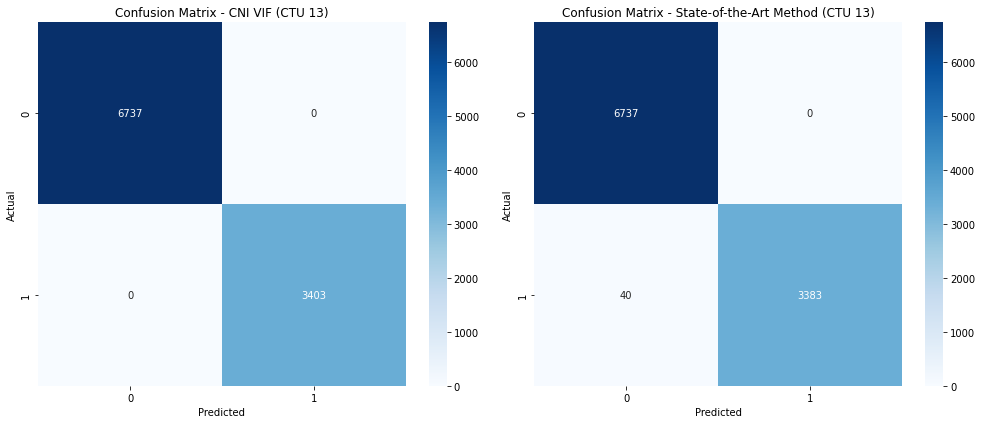

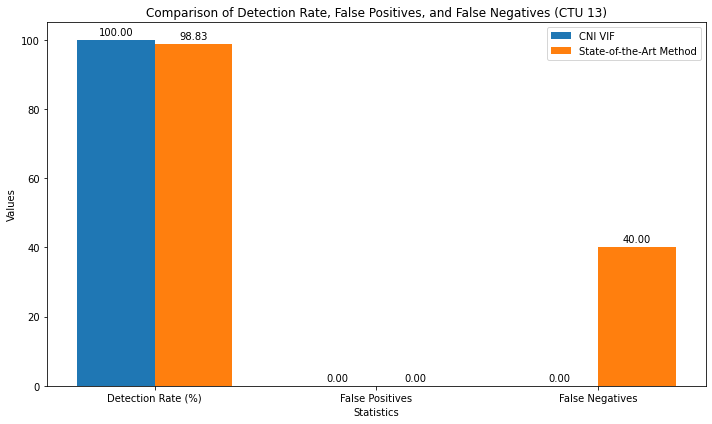

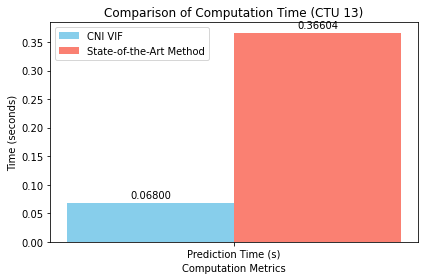

In [144]:
# Call the comparison function with the final results and dataset name
compare_results(results_cni_ctu, results_old_ctu, "CTU 13")

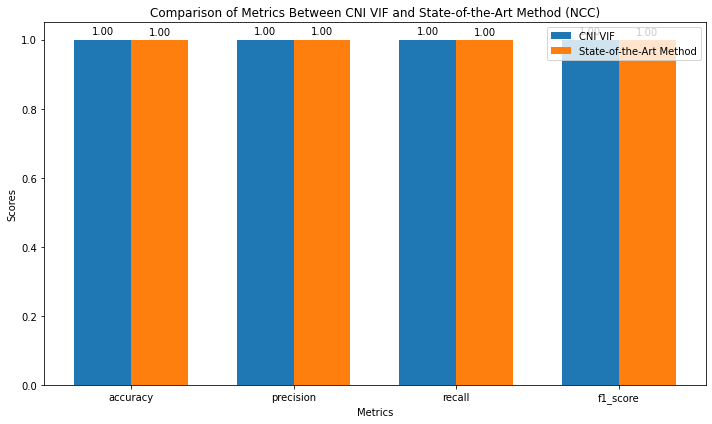

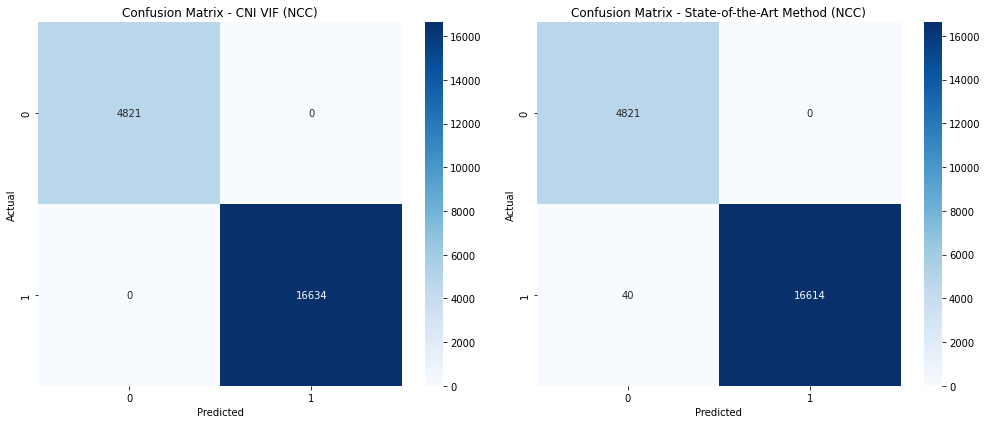

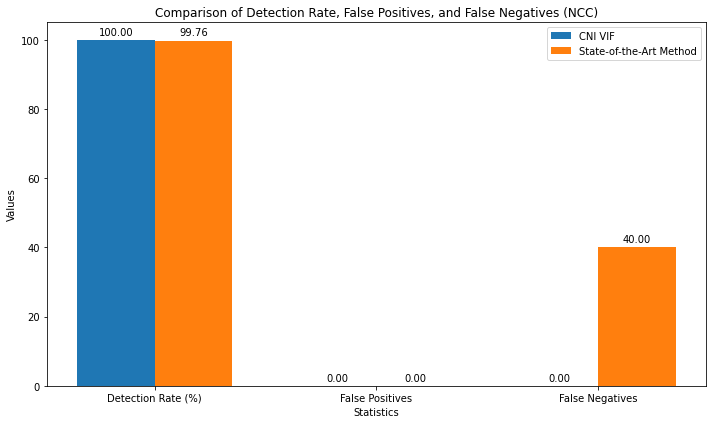

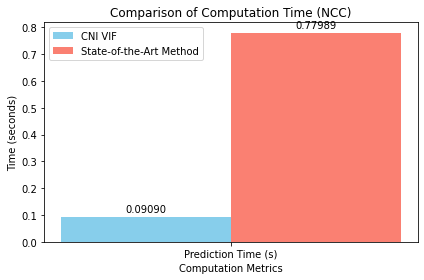

In [145]:
# Call the comparison function with the final results and dataset name
compare_results(results_cni_ncc, results_old_ncc, "NCC")


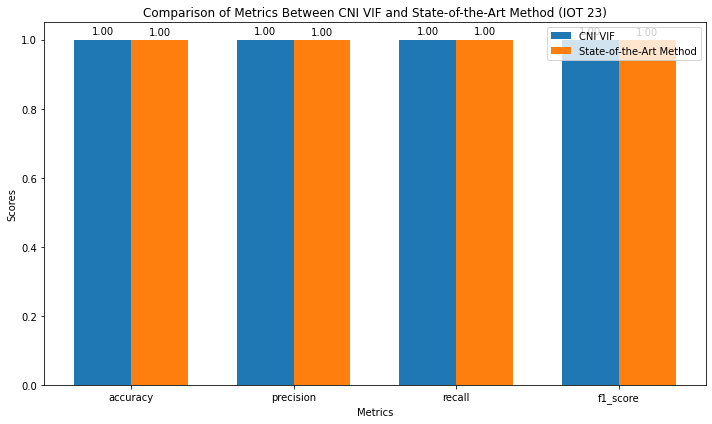

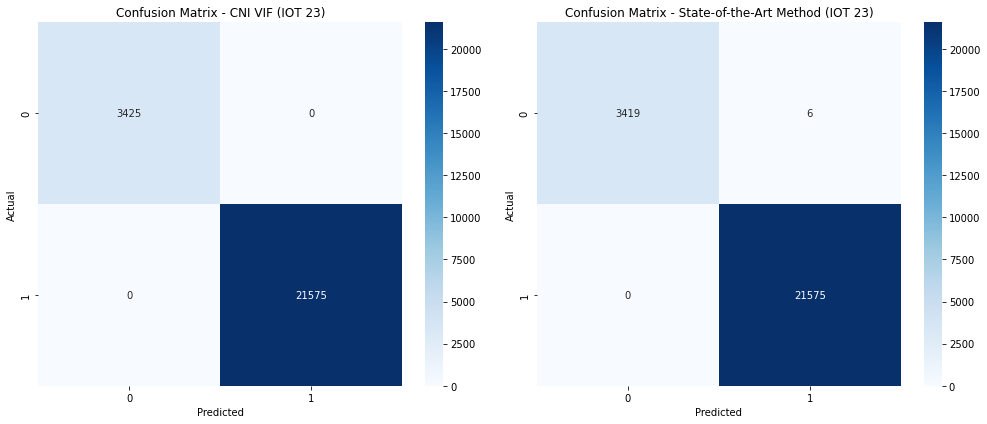

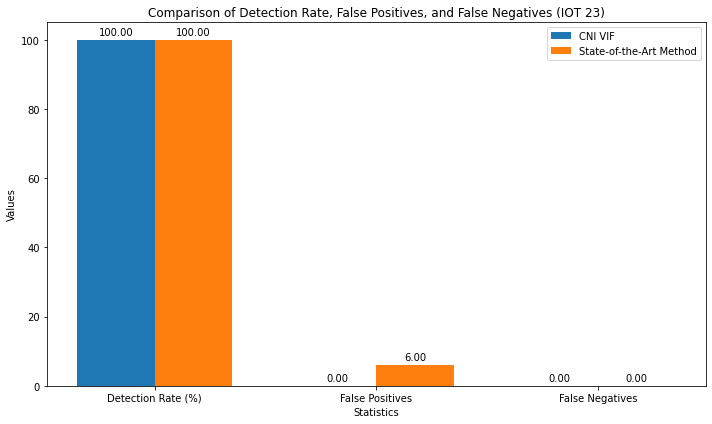

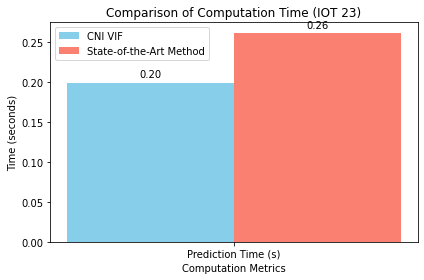

In [33]:
compare_results(results_cni_iot, results_old_iot, "IOT 23")